<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Funet-experiment-1/notebooks/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Unet

This notebook aims to train an Unet to make predictions based on the first 10 images in the dataset, located in data/data_rgb:
- 2022_06_20
- 2022_07_05 ???
- 2022_07_15
- 2022_07_10
- 2022_07_25
- 2022_07_30
- 2022_08_04
- 2022_08_09
- 2022_08_14
- 2022_08_24
- 2022_09_03
- 2022_09_08
- 2022_09_13
- 2022_09_18
- 2022_10_13
- 2022_10_23
- 2022_12_02
- 2022_12_12



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls
%cd drive/MyDrive/MachineLearning
! ls

drive  sample_data
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning
backup		Deep-Learning-with-PyTorch.pdf	original_data
data_colab	Geospatial_ML			Titanic_Challenge.ipynb
data_deep_note	models


In [3]:
#! git clone https://github.com/emely3h/Geospatial_ML
%cd Geospatial_ML
#! git checkout feature/create_mask
#! ls


/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)

14 images in total, as tiles overlap, we don't want to have tiles from the same original image in the training/ test or validation dataset. Therefore we split the dataset accordingly:

- training data: 13
- validation data: 3 images
- test data: 2 images

In [17]:
data_directory = "../data_colab/256_200_1_missing"

# np.load(os.path.join(root_directory, 'y_input.npy'))
# normalize + do one hot encoding while loading

y_train  = np.load(os.path.join(data_directory, 'y_mask_256_200_2022_06_20.npy'))
X_train  = np.load(os.path.join(data_directory, 'x_input_256_200_2022_06_20.npy'))


y_val = np.load(os.path.join(data_directory, 'y_mask_256_200_2022_07_10.npy'))
X_val = np.load(os.path.join(data_directory, 'x_input_256_200_2022_07_10.npy'))

#y_test = np.load(os.path.join(data_directory, 'y_mask_256_200_2022_07_15.npy'))
#X_test = np.load(os.path.join(data_directory, 'x_input_256_200_2022_07_15.npy'))


print(y_train.shape)
print(X_train.shape)

print(y_val.shape)
print(X_val.shape)

#print(y_test.shape)
#print(X_test.shape)

(1251, 256, 256)
(1251, 256, 256, 5)
(1323, 256, 256)
(1323, 256, 256, 5)


In [6]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        #display_list[i][0] = display_list[i][0][..., :4]
        print(display_list[i][0].shape)
        print(display_list[i][1].shape)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

  def display(list_train, list_mask):
    for idx, img_train in enumerate(list_train):
      sample_image, sample_mask = list_train[idx], list_mask[idx]
      sample_image = sample_image[..., :4]
      display_image([sample_image, sample_mask])

(256, 4)
(256, 4)


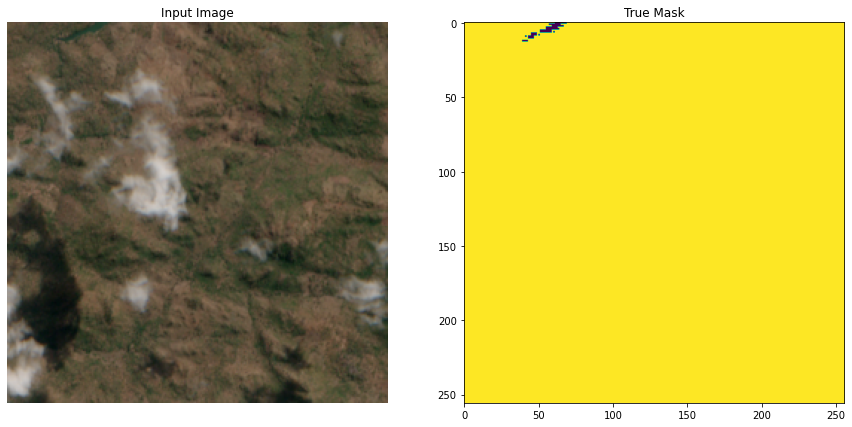

(256, 4)
(256, 4)


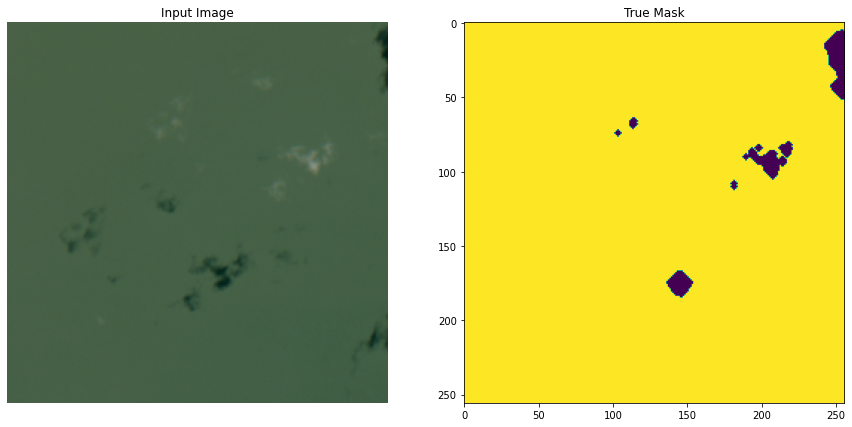

(256, 4)
(256, 4)


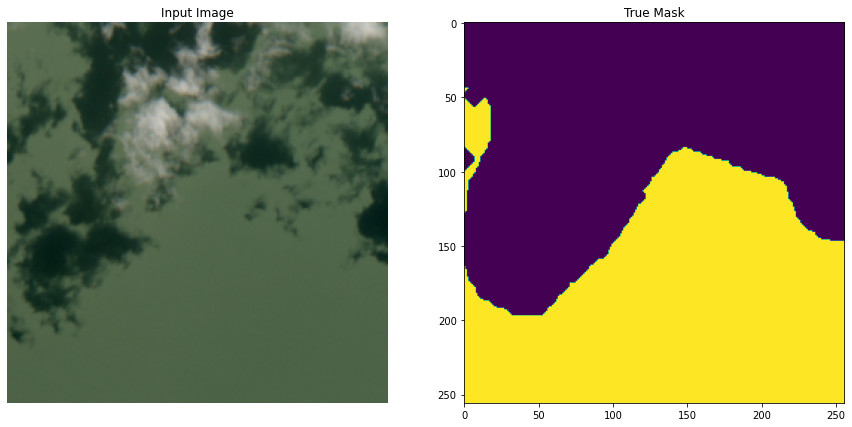

(256, 4)
(256, 4)


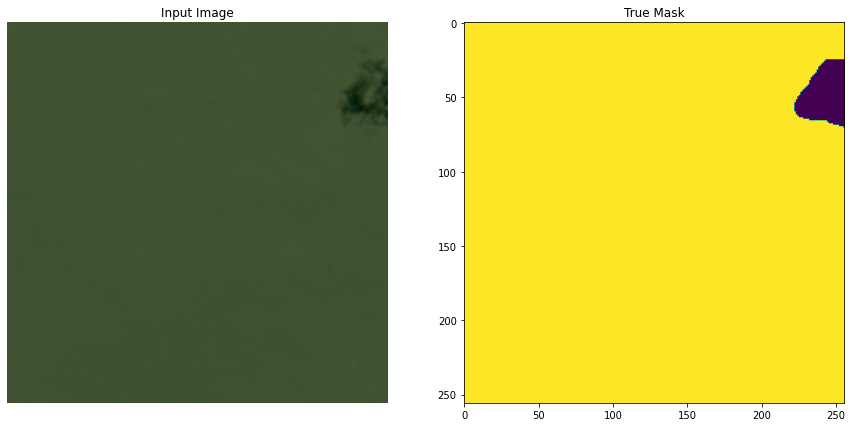

In [7]:
sample_image, sample_mask = X_train[6], y_train[6]

sample_image = sample_image[..., :4]
display_image([sample_image, sample_mask])

sample_image, sample_mask = X_train[5], y_train[5]

sample_image = sample_image[..., :4]
display_image([sample_image, sample_mask])

sample_image, sample_mask = X_train[4], y_train[4]

sample_image = sample_image[..., :4]
display_image([sample_image, sample_mask])

sample_image, sample_mask = X_train[3], y_train[3]

sample_image = sample_image[..., :4]
display_image([sample_image, sample_mask])

#display([X_train[:3], y_train[:3]])


### 2. Normalizing

In [60]:
def normalizing(X, y):

  print(y.shape)
  y_one_hot =  np.array([tf.one_hot(item, depth=3).numpy() for item in y]) # error why depth 4??
  print(y_one_hot.shape)
  X_normal = X/255
  return X_normal, y_one_hot

In [1]:
X_train, y_train = normalizing(X_train, y_train)

X_val, y_val = normalizing(X_val, y_val)

#X_test, y_test = normalizing(X_test, y_test)


NameError: ignored

In [10]:
print(np.max(y_train))
print(np.min(y_train))

1.0
0.0


### 3. Building the unet model

In [11]:
def unet_2d(input_shape, num_classes):

    # Define the input layer
    inputs = Input(input_shape)

    # Downsample layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsample layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Define the model
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [31]:
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1, dropout=0.1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path

    # e.g., (width, height) = (128, 128)
    # 128x128x3(input) -> 128x128x16(c1)
    c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(dropout)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    # 128x128x16(c1) -> 64x64x16(p1)
    p1 = MaxPooling2D((2, 2))(c1)
    # 64x64x16(p1) -> 64x64x32(c2)


    c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(dropout)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    # 64x64x32(c2) -> 32x32x32(p2)
    p2 = MaxPooling2D((2, 2))(c2)
    # 32x32x32(p2) -> 32x32x64(c3)


    c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    # 32x32x64(c3) -> 16x16x64(p3)
    p3 = MaxPooling2D((2, 2))(c3)
    # 32x32x64(p3) -> 16x16x128(c4)


    c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    # 16x16x128(c4) -> 8x8x128(p4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    # 8x8x128(p4) -> 8x8x256(c5)


    c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    # Expansive path
    # 8x8x256(c5) -> 16x16x128(u6) // u = up-sampling
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    # 16x16x128(u6), 16x16x128(c4) -> u6 = 32x32x128(u6, c4)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)
    # 32x32x128(c6) -> 32x32x64(u7)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    # 32x32x64(u7), 32x32x64(c3) -> u7 = 64x64x64(u7, c3)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)
    # 64x64x64(c7) -> 64x64x32(u8)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
    # 64x64x32(c2), 64x64x32(u8) -> u8 = 128x128x32(u8, c2)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)
    # 128x128x32(c8) -> 128x128x16(u9)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
    # 128x128x16(c1), 128x128x16(u9) -> u9 = 128x128x32(u9, c1)//axis=3: concatenate along the channel axis
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)
    # 128x128x32(c9) -> 128x128x2(outputs) -> 2 layers: background, foreground

    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    # NOTE: Compile the model in the main program to make it easy to test with various loss functions
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()

    return model

In [51]:

from keras.losses import categorical_crossentropy
model = multi_unet_model(4, 256, 256, 5)
#model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
#model.summary()

### 4. Training the model

In [13]:


# Hyperparameters
training_parameters = {
    "loss": "binary_crossentropy",
    "optimizer": "adam",
    "monitored_func": "val_loss",
    "epochs": 100,
}



In [27]:
print(X_train[0].shape)
print(y_train[0].shape)

(256, 256, 5)
(256, 256)


In [14]:
print(X_train.shape)
print(y_train.shape)

(1251, 256, 256, 5)
(1251, 256, 256, 4)


In [53]:
model.compile(optimizer='adam',
              loss=categorical_crossentropy, # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor=training_parameters["monitored_func"], patience=5, restore_best_weights=True)
model_history = model.fit(x=X_train, y=y_train, epochs=5)



Epoch 1/5
40/40 [==============================] - 28s 391ms/step - loss: 0.6348 - accuracy: 0.7492
Epoch 2/5
40/40 [==============================] - 14s 362ms/step - loss: 0.1763 - accuracy: 0.9459
Epoch 3/5
40/40 [==============================] - 15s 368ms/step - loss: 0.1003 - accuracy: 0.9664
Epoch 4/5
40/40 [==============================] - 15s 371ms/step - loss: 0.0852 - accuracy: 0.9701
Epoch 5/5
40/40 [==============================] - 15s 366ms/step - loss: 0.0743 - accuracy: 0.9729


In [56]:
loss = model_history.history['loss']
print(model_history.history)


{'loss': [0.15089039504528046, 0.08233358711004257, 0.06922097504138947, 0.06325996667146683, 0.059120722115039825], 'accuracy': [0.950828492641449, 0.9729793071746826, 0.9752857089042664, 0.9772077798843384, 0.9783838987350464]}


In [59]:
print(y_train[0][0])

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


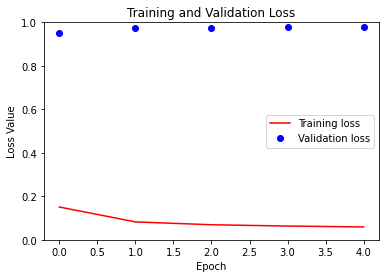

In [58]:
val_loss = model_history.history['accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 5. Saving the model

In [ ]:
model_name = '256_200.h5'
#model.save(f'../models/{model_name}')

model = keras.models.load_model(f'../models/{model_name}')

In [ ]:
predictions = model.predict(X_test)

27/27 [==============================] - 2s 63ms/step


In [ ]:
def jacard_coef(y_true, y_pred):
  y_true_f = keras.backend.flatten(y_true)
  y_pred_f = keras.backend.flatten(y_pred)
  intersection = keras.backend.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (
      keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection + 1.0
  )

In [ ]:
jacard_result = jacard_coef(y_test, predictions)
print(jacard_result)

tf.Tensor(0.8130482, shape=(), dtype=float32)


### 6. Analyzing the results
- predifined success metrics
- printing loss and validation functions
- making predictions

### 7. Summary